# Experiments with the ADS1015 ADC

Using the Adafruit breakout board.

In [1]:
import time
import board
import busio
import adafruit_ads1x15.ads1015 as ADS
from adafruit_ads1x15.ads1x15 import Mode
from adafruit_ads1x15.analog_in import AnalogIn
import numpy as np

# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [24]:
# only certain discrete rates are allowed.  3300 is the highest
RATE = 3300

# Create the I2C bus
i2c = busio.I2C(board.SCL, board.SDA)

# Create the ADC object using the I2C bus
ads = ADS.ADS1015(i2c, address=0x49)
ads.gain = 2     # only discrete values allowed

# Create single-ended input on channel 0
#chan = AnalogIn(ads, ADS.P0)

# Create differential input between channel x and 3
# P0 - P2 can be measured relative to P3. No other pin can
# be the common for all channels.
chan = AnalogIn(ads, ADS.P2, ADS.P3)

ads.mode = Mode.CONTINUOUS
ads.data_rate = RATE

# Investigate how many samples are needed to minimize Sampling error.
SAMPLES = 500
data = [None] * SAMPLES
arr_rms = []
for i in range(20):
    st = time.monotonic()
    for i in range(SAMPLES):
        data[i] = chan.voltage
        #time.sleep(.5)
    en = time.monotonic()
    tot_time = en - st
    print(tot_time, end=', ')
    print(SAMPLES / tot_time, end=', ')
    arr = np.array(data)
    arr2 = arr * arr
    rms = arr2.mean() ** 0.5
    print(rms)
    arr_rms.append(rms)
arr_rms = np.array(arr_rms)
print(f'Std Dev: {arr_rms.std()}')

0.2017268800000238, 2478.5987866363716, 0.130540124357937
0.18011442499982877, 2776.0130816866854, 0.13008609012884179
0.19030921100011255, 2627.3032049915037, 0.1313434083118093
0.2873947040002349, 1739.7676193768389, 0.13069673509483015
0.187279677999868, 2669.8038214287853, 0.13012335469404832
0.20139779100009036, 2482.6488787048097, 0.13077283272476461
0.17967763000024206, 2782.761549110629, 0.1298146006365059
0.23990184500007672, 2084.185721872377, 0.12999828249306417
0.3498098019999816, 1429.348169037374, 0.13043091017011293
0.17950582599996778, 2785.424914287126, 0.13042775884615543
0.1994642899999235, 2506.7143597492654, 0.13035004810416392
0.17946500700008983, 2786.0584542798906, 0.13135436453589916
0.29844807600011336, 1675.3332998528363, 0.12917971397411304
0.34276859300007345, 1458.7100749918848, 0.13112712702642595
0.17894412699979512, 2794.1682601327984, 0.13051371440040324
0.19051960399974632, 2624.401843710875, 0.12979223468308565
0.1790034079999714, 2793.242908537696, 

In [9]:
n = 10
iter_sum = 0.0
for i in range(10):
    for i in range(SAMPLES):
        data[i] = chan.voltage
    arr = np.array(data)
    arr2 = arr * arr
    rms = arr2.mean() ** 0.5
    iter_sum += rms
    #print(f'{rms:.3f}')
    #time.sleep(.3)
print(f'{iter_sum / n:.4f}')

0.1310


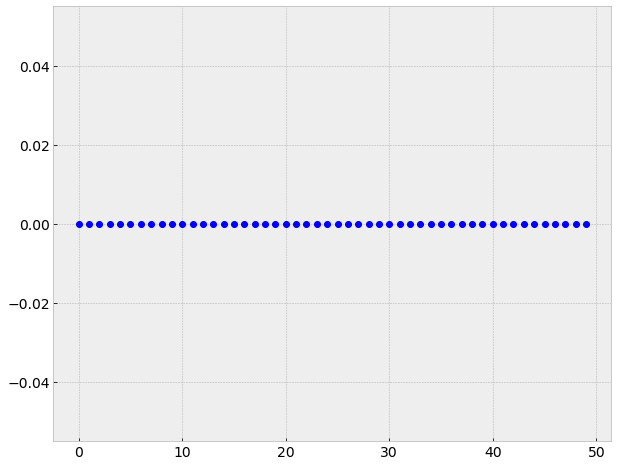

In [264]:
plot(data[:50], 'bo')

In [226]:
#!/usr/bin/env python3
"""Reader module for reporting information about the operation
of the monitoring system.
"""
import time
import base_reader
import board
import busio
import adafruit_ads1x15.ads1015 as ADS
from adafruit_ads1x15.ads1x15 import Mode
from adafruit_ads1x15.analog_in import AnalogIn
import numpy as np

SAMPLES = 500  # samples per channel to calculate RMS
RATE = 3300    # samples/second, fastest rate available

class RMS_3ch(base_reader.Reader):
    
    def read(self):

        # Create the I2C bus
        i2c = busio.I2C(board.SCL, board.SDA)

        # Create the ADC object using the I2C bus
        ads = ADS.ADS1015(i2c)
        ads.gain = 2    # only discrete values allowed
        ads.mode = Mode.CONTINUOUS
        ads.data_rate = RATE
        
        # Channels to cycle through and read, along with channel number identifier
        channels = [
            (ADS.P0, 0),
            (ADS.P1, 1),
            (ADS.P2, 2)
        ]

        # use the same timestamp for all three channels
        ts = time.time()
        data = [None] * SAMPLES
        readings = []

        for ads_ch, ch_id in channels:
            sensor_id = f'{self._settings.LOGGER_ID}_ch{ch_id}'

            # Create differential input between this channel and channel 3.
            chan = AnalogIn(ads, ads_ch, ADS.P3)
            
            for i in range(SAMPLES):
                data[i] = chan.voltage
            arr = np.array(data)
            arr2 = arr * arr
            rms = arr2.mean() ** 0.5
            readings.append((ts, sensor_id, rms, base_reader.VALUE))

        return readings


[(1571897094.993461, 'test_uptime', 90800, 3),
 (1571897094.993461, 'test_cpu_temp', 61.348, 1),
 (1571897094.993461, 'test_version', 0.0, 2)]
